# CSE527 Homework 5 - 1
**Due date: 11:59 pm EST on Dec. 1, 2022 (Thu.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd '/content/gdrive/MyDrive/Basak_Hritam_114783055_HW5'

/content/gdrive/MyDrive/Basak_Hritam_114783055_HW5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [ ]:
# download the dataset
#! chmod +x ./download_dataset.sh
#! ./download_dataset.sh

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random 
import time
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

<Figure size 720x720 with 0 Axes>

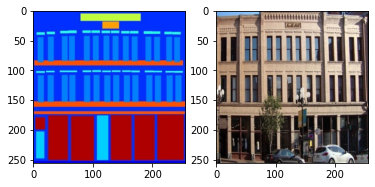

In [ ]:
plt.figure(figsize=(10, 10))
fig, (ax1, ax2)  = plt.subplots(1, 2)

def normalize(image1, image2):
    transform = T.Compose([
        T.Resize(256),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image1 = transform(image1)
    image2 = transform(image2)
    return image1, image2

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for i in image_names:
      image = Image.open(i).convert('RGB')
      w, h = image.size
      image1 = image.crop((0, 0, w//2, h))
      image2 = image.crop((w//2, 0, w, h))
      image1, image2 = normalize(image1, image2)
      image1 = T.Resize((256,256))(image1)
      image2 = T.Resize((256,256))(image2)
      data.append((image2, image1))
    
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')

def denormalize(image):
    #mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    #std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    #image1 = image1 * std + mean
    #image2 = image2 * std + mean
    #image1 = torch.clip(image1, 0., 1.)
    #image2 = torch.clip(image2, 0., 1.)
    min_val = -1
    max_val = 1
    image = (image - min_val)/(max_val - min_val)
    return image


def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########
    image1 = denormalize(s_left)
    image2 = denormalize(s_right)
    image1 = image1.permute(1, 2, 0)
    image2 = image2.permute(1, 2, 0)
    ax1.imshow(image1)
    ax2.imshow(image2)
    
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
class ConvBlockEncoder(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True):
        super(ConvBlockEncoder, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        #self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        out = self.conv(x)
        if self.batch_norm:
          out = self.bn(out)
        out = self.lrelu(out)
        
        return out

class ConvBlockDecoder(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout = False):
        super(ConvBlockDecoder, self).__init__()
        self.conv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        #self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = dropout
        self.drop_out = torch.nn.Dropout(0.5)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        if self.drop:
          out = self.drop_out(out)
        out = self.relu(out)
        
        return out

# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        self.conv1 = ConvBlockEncoder(n_channels, 64, batch_norm = False)
        self.conv2 = ConvBlockEncoder(64, 128)
        self.conv3 = ConvBlockEncoder(128, 256)
        self.conv4 = ConvBlockEncoder(256, 512, stride = 1) 
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1)

        ##########-------END OF CODE-------##########
        
    def forward(self, x, label):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x, label], dim=1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        x_d = torch.nn.Sigmoid()(out)
        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
# feel free to do some sanity check here
data = torch.rand(2, 3, 256, 256)
netD = Discriminator(6)
out = netD(data, data)
print(out.shape)

##########-------END OF CODE-------##########    

torch.Size([2, 1, 30, 30])


In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########

        #Encoder part
        self.conv1 = ConvBlockEncoder(n_channels, 64, batch_norm = False)
        self.conv2 = ConvBlockEncoder(64, 128)
        self.conv3 = ConvBlockEncoder(128, 256)
        self.conv4 = ConvBlockEncoder(256, 512) 
        self.conv5 = ConvBlockEncoder(512, 512) 
        self.conv6 = ConvBlockEncoder(512, 512) 
        self.conv7 = ConvBlockEncoder(512, 512) 
        self.conv8 = ConvBlockEncoder(512, 512, batch_norm = False) 
        

        #Decoder part
        self.deconv1 = ConvBlockDecoder(512, 512, dropout = True)
        self.deconv2 = ConvBlockDecoder(2*512, 512, dropout = True)
        self.deconv3 = ConvBlockDecoder(2*512, 512, dropout = True)
        self.deconv4 = ConvBlockDecoder(2*512, 512)
        self.deconv5 = ConvBlockDecoder(2*512, 256)
        self.deconv6 = ConvBlockDecoder(2*256, 128)
        self.deconv7 = ConvBlockDecoder(2*128, 64)
        self.deconv8 = nn.ConvTranspose2d(2*64, 3, kernel_size=4, stride=2, padding=1)
        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        #encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        #decoder
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        x_g = torch.nn.Tanh()(dec8)
        
        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
# netG = # initialize the discriminator
# netGL1 = 
# feel free to do some sanity check here
netG = GeneratorUNet(3)
data = torch.rand(2, 3, 256, 256)
out = netG(data)
print(out.shape)
##########-------END OF CODE-------##########  

torch.Size([2, 3, 256, 256])


### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--##########
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#netG = netG.to(device)
#netD = netD.to(device) 
g_optimizer = torch.optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))
##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [ ]:
class LossDiscriminator(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    def forward(self, fake_pred, real_pred):
        real_target = torch.ones_like(real_pred)
        fake_target = torch.zeros_like(fake_pred)
        
        real_loss = self.loss_fn(real_pred, real_target)
        fake_loss = self.loss_fn(fake_pred, fake_target)

        final_loss = 0.5 * (fake_loss + real_loss)
        return final_loss

class LossGenerator(nn.Module):
    def __init__(self, lambd=100):
        super().__init__()
        self.lambd = lambd
        self.bce = nn.BCEWithLogitsLoss()
        self.l1 = nn.L1Loss()
        
    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        final_loss = self.bce(fake_pred, fake_target) + self.lambd * self.l1(fake, real)
        return final_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
#netG.train()
#netD.train()

In [ ]:


##########--WRITE YOUR CODE HERE--########## 
trainData = torch.utils.data.DataLoader(dataset=train, batch_size=1, shuffle=True)

avg_loss_Generator = []
avg_loss_Discriminator = []
epochs = 50

#loss
lossDCriterion = LossDiscriminator()
lossGCriterion = LossGenerator(lambd = 100) 

for epoch in range(epochs):
    total_loss_disc = 0.0
    total_loss_gen = 0.0
    start = time.time()
    for i, (x, y) in enumerate(trainData):

      x = x.to(device)
      y = y.to(device)
      real_pred = netD(y, x)
      fake = netG(x).detach()
      fake_pred = netD(fake, x)
      
      loss_discriminator = lossDCriterion(fake_pred, real_pred)

      # Discriminator params update
      d_optimizer.zero_grad()
      loss_discriminator.backward()
      d_optimizer.step()

      # Generator loss
      fake = netG(x)
      fake_pred = netD(fake, x)
      loss_generator = lossGCriterion(fake, y, fake_pred)

      # Generator params update
      g_optimizer.zero_grad()
      loss_generator.backward()
      g_optimizer.step()

      
      total_loss_gen += loss_generator.item()
      total_loss_disc += loss_discriminator.item()
    
    end = time.time()
    timetaken = (end - start)
    
    avg_loss_Discriminator.append(total_loss_disc/len(trainData))
    avg_loss_Generator.append(total_loss_gen/len(trainData))
    print('Epoch [%d/%d], D_loss: %.4f, G_loss: %.4f, ETA: %.3fs'
                % (epoch+1, epochs, avg_loss_Discriminator[-1], avg_loss_Generator[-1], timetaken))

##########-------END OF CODE-------##########

Epoch [1/50], D_loss: 0.5733, G_loss: 43.4358, ETA: 48.218s
Epoch [2/50], D_loss: 0.5431, G_loss: 38.0092, ETA: 47.783s
Epoch [3/50], D_loss: 0.5307, G_loss: 36.9004, ETA: 47.909s
Epoch [4/50], D_loss: 0.5232, G_loss: 36.2988, ETA: 47.744s
Epoch [5/50], D_loss: 0.5124, G_loss: 35.6909, ETA: 47.762s
Epoch [6/50], D_loss: 0.5076, G_loss: 35.3867, ETA: 47.806s
Epoch [7/50], D_loss: 0.5077, G_loss: 35.1528, ETA: 47.797s
Epoch [8/50], D_loss: 0.5091, G_loss: 34.9379, ETA: 47.750s
Epoch [9/50], D_loss: 0.5064, G_loss: 34.6096, ETA: 47.759s
Epoch [10/50], D_loss: 0.5084, G_loss: 34.3813, ETA: 47.850s
Epoch [11/50], D_loss: 0.5041, G_loss: 34.1095, ETA: 47.784s
Epoch [12/50], D_loss: 0.5043, G_loss: 33.5752, ETA: 47.772s
Epoch [13/50], D_loss: 0.5037, G_loss: 33.1339, ETA: 47.820s
Epoch [14/50], D_loss: 0.5062, G_loss: 32.6175, ETA: 47.831s
Epoch [15/50], D_loss: 0.5036, G_loss: 32.1678, ETA: 47.754s
Epoch [16/50], D_loss: 0.5085, G_loss: 31.3621, ETA: 47.789s
Epoch [17/50], D_loss: 0.5055, G_

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netGL1 = GeneratorUNet(3)
netGL1 = netGL1.to(device)

g_optimizer = torch.optim.Adam(netGL1.parameters(), lr = 0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))
#netGL1.train()

In [ ]:
class LossGeneratorL1(nn.Module):
    def __init__(self,):
        super().__init__()
        #self.lambd = lambd
        #self.bce = nn.BCEWithLogitsLoss()
        self.l1 = nn.L1Loss()
        
    def forward(self, fake, real):
        #fake_target = torch.ones_like(fake_pred)
        final_loss = self.l1(fake, real)
        return final_loss



##########--WRITE YOUR CODE HERE--########## 
avg_loss_Generator_L1 = []
#avg_loss_Discriminator = []
epochs = 50
trainData = torch.utils.data.DataLoader(dataset=train, batch_size=1, shuffle=True)

#loss
#lossDCriterion = LossDiscriminator()
lossGCriterion = LossGeneratorL1() 

for epochl1 in range(epochs):
    #total_loss_disc = 0.0
    total_loss_gen = 0.0
    start = time.time()
    for i, (x, y) in enumerate(trainData):
      # Generators loss
      x = x.to(device)
      y = y.to(device)
      fake = netGL1(x)
      #fake_pred = netD(fake, x)
      loss_generator = lossGCriterion(fake, y)

      # Generator`s params update
      g_optimizer.zero_grad()
      loss_generator.backward()
      g_optimizer.step()

      # add batch losses
      total_loss_gen += loss_generator.item()
      #total_loss_disc += loss_discriminator.item()
    
    end = time.time()
    timetaken = (end - start)
    
    #avg_loss_Discriminator.append(total_loss_disc/len(trainData))
    avg_loss_Generator_L1.append(total_loss_gen/len(trainData))
    print('Epoch [%d/%d], G_loss: %.4f, ETA: %.3fs'
                % (epochl1+1, epochs, avg_loss_Generator_L1[-1], timetaken))



##########-------END OF CODE-------##########

Epoch [1/50], G_loss: 0.4307, ETA: 24.003s
Epoch [2/50], G_loss: 0.3670, ETA: 23.904s
Epoch [3/50], G_loss: 0.3580, ETA: 23.821s
Epoch [4/50], G_loss: 0.3537, ETA: 23.844s
Epoch [5/50], G_loss: 0.3514, ETA: 23.881s
Epoch [6/50], G_loss: 0.3489, ETA: 23.923s
Epoch [7/50], G_loss: 0.3469, ETA: 23.882s
Epoch [8/50], G_loss: 0.3451, ETA: 23.876s
Epoch [9/50], G_loss: 0.3426, ETA: 23.839s
Epoch [10/50], G_loss: 0.3405, ETA: 23.853s
Epoch [11/50], G_loss: 0.3375, ETA: 23.914s
Epoch [12/50], G_loss: 0.3338, ETA: 23.867s
Epoch [13/50], G_loss: 0.3292, ETA: 23.898s
Epoch [14/50], G_loss: 0.3239, ETA: 23.932s
Epoch [15/50], G_loss: 0.3184, ETA: 23.860s
Epoch [16/50], G_loss: 0.3098, ETA: 23.859s
Epoch [17/50], G_loss: 0.3025, ETA: 23.854s
Epoch [18/50], G_loss: 0.2964, ETA: 23.836s
Epoch [19/50], G_loss: 0.2891, ETA: 23.907s
Epoch [20/50], G_loss: 0.2830, ETA: 23.868s
Epoch [21/50], G_loss: 0.2782, ETA: 23.853s
Epoch [22/50], G_loss: 0.2717, ETA: 23.894s
Epoch [23/50], G_loss: 0.2679, ETA: 23.92

In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epoch,
    'lossD': avg_loss_Discriminator,
    'lossG': avg_loss_Generator,
    }, 'pix2pix.pth')
#saving the first model with the combined loss


In [ ]:
torch.save({
    'G': netGL1.state_dict(),
    'epoch': epochl1,
    'lossGL1': avg_loss_Generator_L1,
    }, 'pix2pixL1.pth')
### Saving the L1 model

In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
loss_iter_G = checkpoint['lossG']
loss_iter_D = checkpoint['lossD']

path = "pix2pixL1.pth"
checkpoint = torch.load(path, map_location=torch.device('cpu'))
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
loss_iter_l1 = checkpoint['lossGL1']

#print(loss_iter_D)
#print(loss_iter_G)
#print(loss_iter_l1)

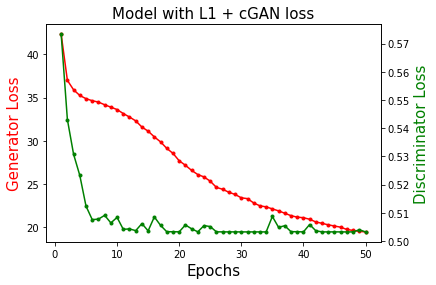

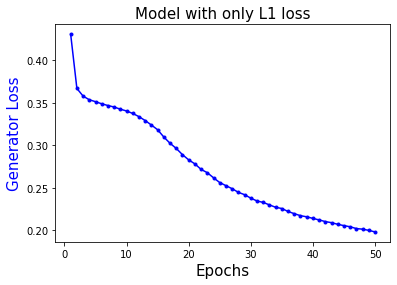

In [ ]:
# Plot the loss
##########--WRITE YOUR CODE HERE--##########
epochs = 50
_, new_axis = plt.subplots()

new_axis.set_xlabel("Epochs", fontsize = 15)
new_axis.set_ylabel("Generator Loss", color = 'red', fontsize = 15)
new_axis.plot(range(1, epochs + 1), np.array(loss_iter_G)*100, color = "red", marker = ".")
plt.title("Model with L1 + cGAN loss", fontsize = 15)

axis = new_axis.twinx()
axis.set_xlabel("Epochs", fontsize = 15)
axis.set_ylabel("Discriminator Loss", color = 'green', fontsize = 15)
axis.plot(range(1, epochs + 1), loss_iter_D, color = "green", marker = ".")
plt.show()


fig, axis = plt.subplots()
axis.set_xlabel("Epochs", fontsize = 15)
axis.set_ylabel("Generator Loss", color = 'blue', fontsize = 15)
axis.plot(range(1, epochs + 1), loss_iter_l1, color = "blue", marker = ".")
plt.title("Model with only L1 loss", fontsize = 15)
plt.show()

##########-------END OF CODE-------##########

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

<Figure size 432x288 with 0 Axes>

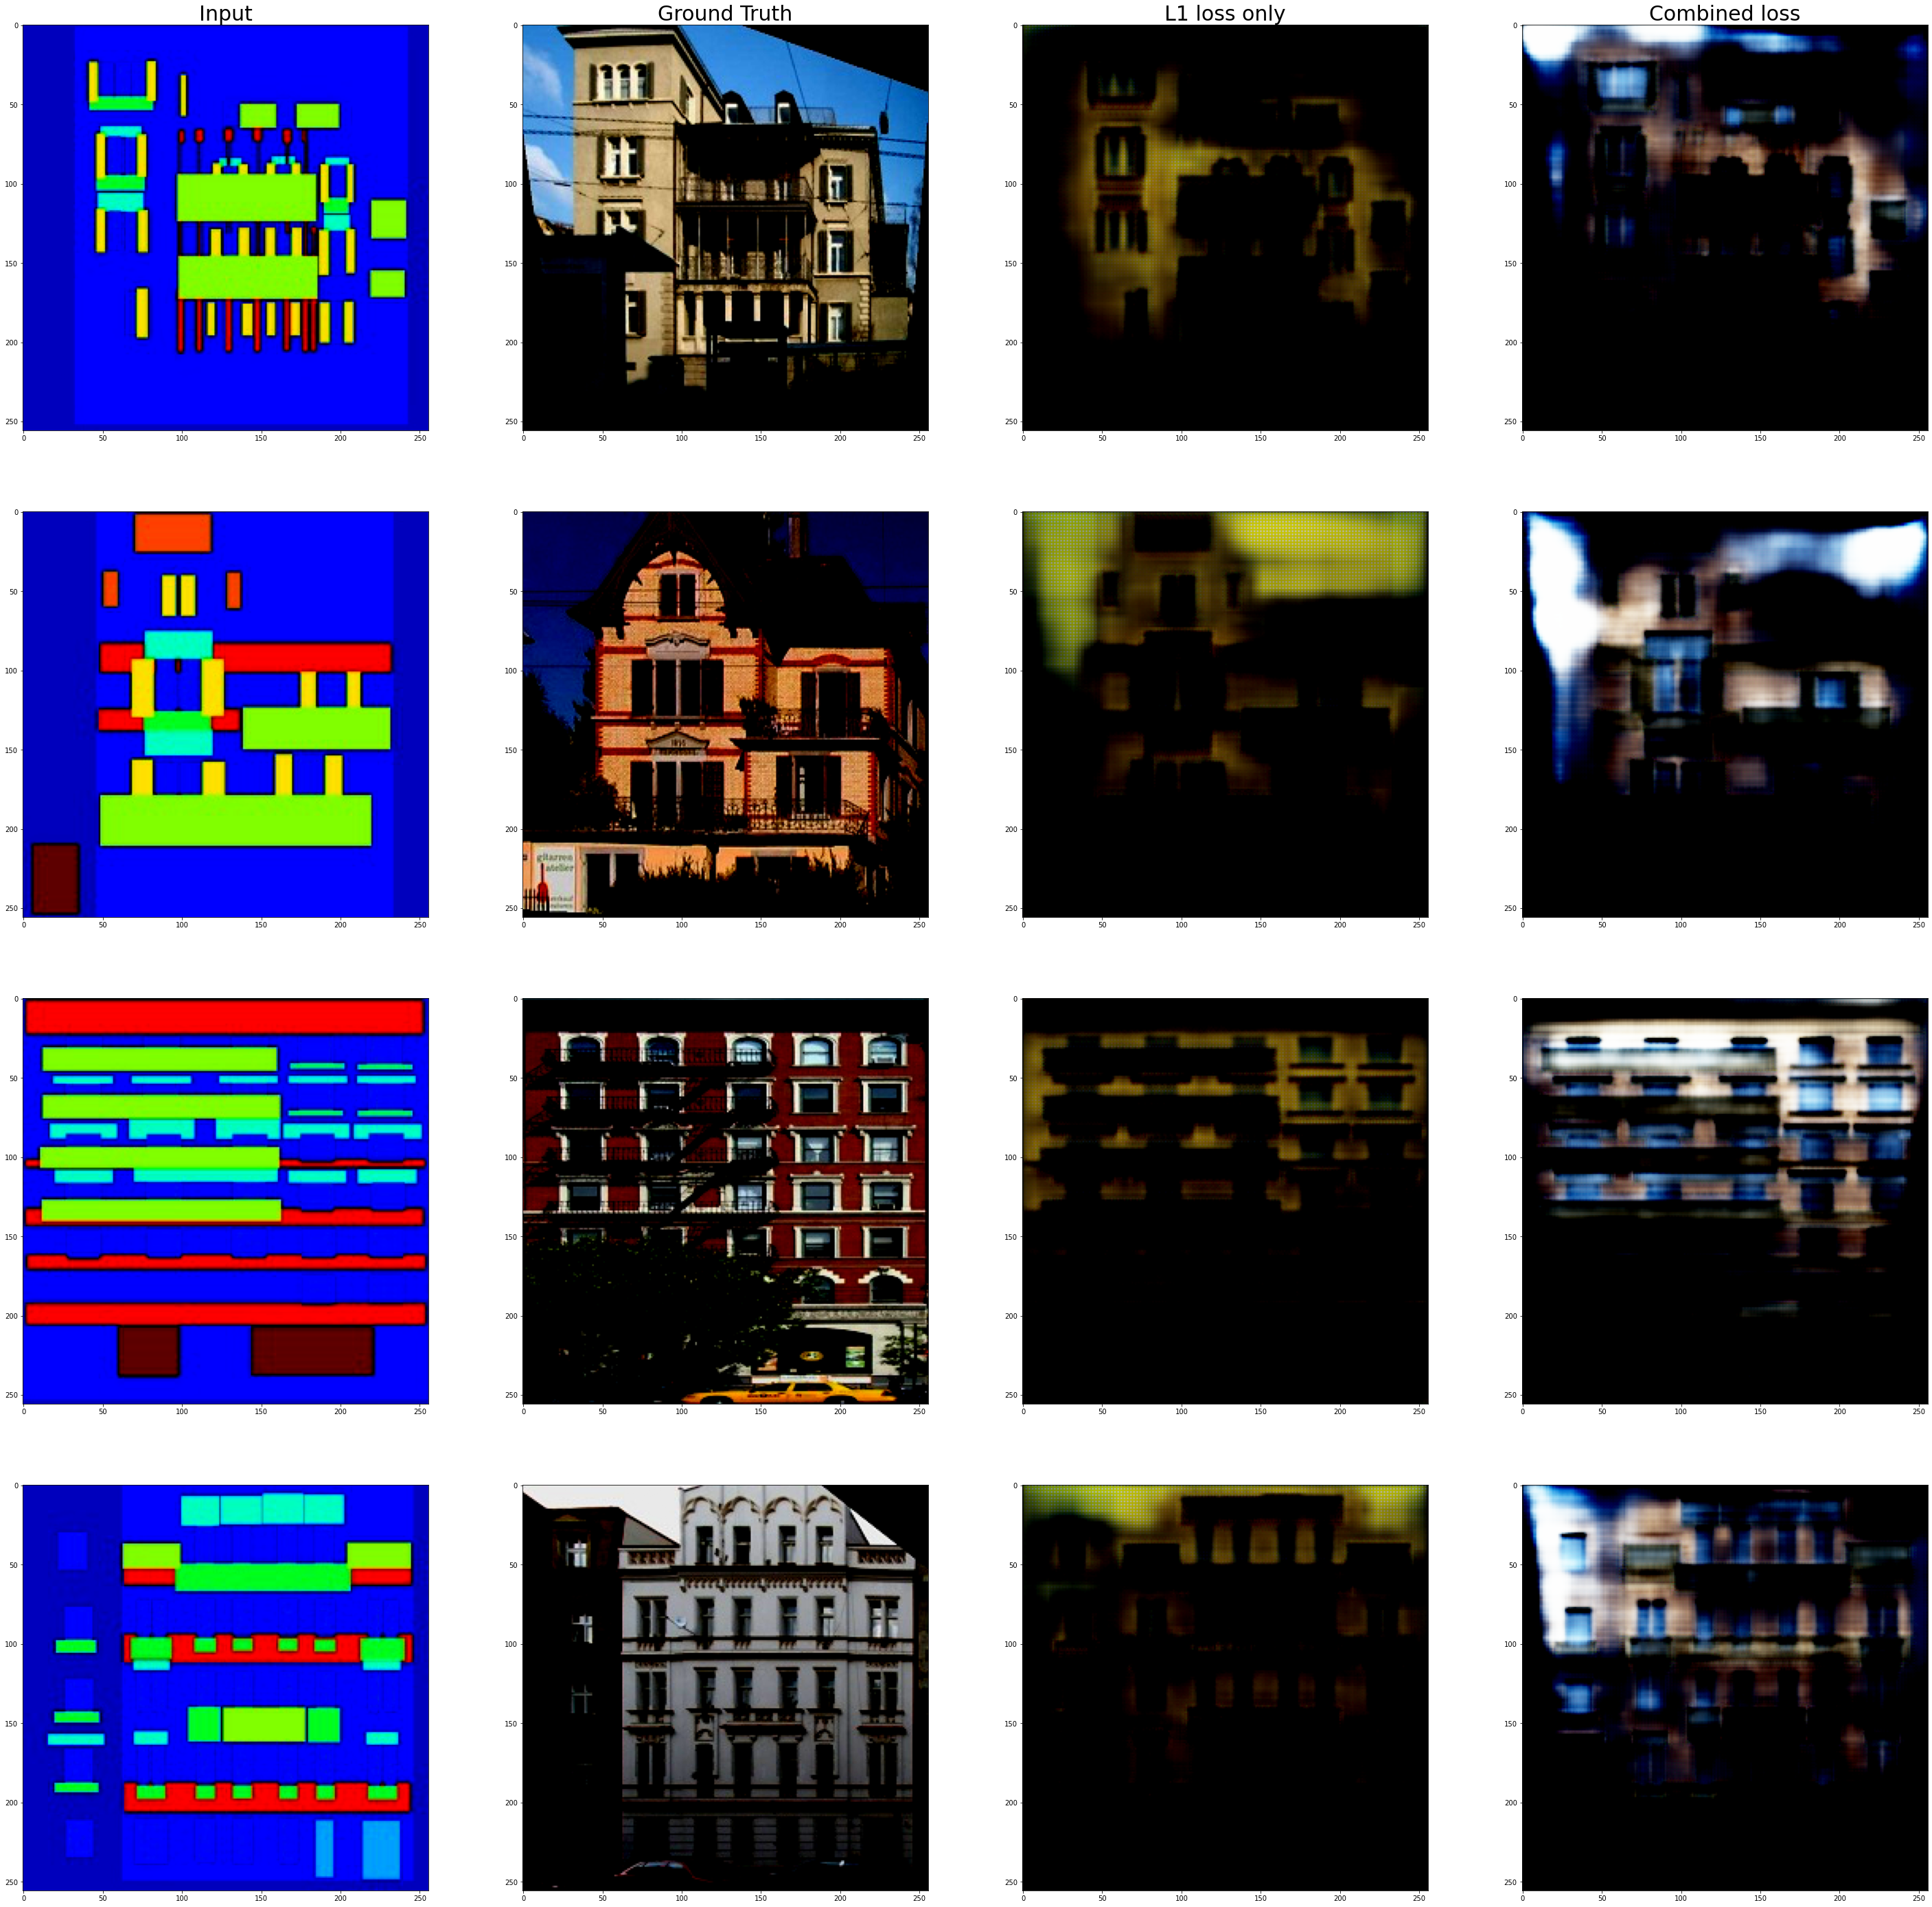

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first


netG = netG.to(device)
netGL1 = netGL1.to(device)
netG.eval()
netGL1.eval()
##########--WRITE YOUR CODE HERE--##########
def show_img_pair(data, n):
    # convert the pixels back to [0, 1] when visualizing
    plt.figure()
    _, axxr  = plt.subplots(n, 4, figsize = (50, 50))
    axxr[0, 0].set_title('Input', fontsize = 30)
    axxr[0, 1].set_title('Ground Truth', fontsize = 30)
    axxr[0, 2].set_title('L1 loss only', fontsize = 30)
    axxr[0, 3].set_title('Combined loss', fontsize = 30)

    for i in range (n):
        image1 = data[i][0]
        image2 = data[i][1]
        
        #image1, image2 = denormalize(s_left, s_right)
        #image1 = T.Resize((256,256))(image1).to(device)
        #image2 = T.Resize((256,256))(image2).to(device)
        image1 = image1.to(device).unsqueeze(0)
        image2 = image2.to(device).unsqueeze(0)
        image3 = netGL1(image1).permute(0, 2, 3, 1).detach().cpu().numpy()
        image4 = netG(image1).permute(0, 2, 3, 1).detach().cpu().numpy()
        image1 = image1.permute(0, 2, 3, 1).detach().cpu().numpy()
        image2 = image2.permute(0, 2, 3, 1).detach().cpu().numpy()
        image1 = image1.squeeze(0)
        image2 = image2.squeeze(0)
        image3 = image3.squeeze(0)
        image4 = image4.squeeze(0)

        axxr[i,0].imshow(image1)
        axxr[i,1].imshow(image2)
        axxr[i,2].imshow(image3)
        axxr[i,3].imshow(image4)
    ##########-------END OF CODE-------##########    
    
    
show_img_pair(test, 4)

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import torch 
netG.eval()
netD.eval()
netGL1.eval()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def resize_image(x):
  with torch.no_grad():
    x = up(x)
    x = inception_model(x)
    return F.softmax(x).data.cpu().numpy()
def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
  with torch.no_grad():
    split_scores = []
    pred = np.zeros((images.shape[0], 1000))
    data = torch.utils.data.DataLoader(images, 4)
    for i,x in enumerate(data):
        x = x.to(device).type(dtype)
        batch_variable = torch.autograd.Variable(x)
        bs_i = x.shape[0]

        pred[i*4:i*4+bs_i] = resize_image(batch_variable)
    for j in range(splits):
        p = pred[j*(images.shape[0] // splits): (j+1) * (images.shape[0] // splits), :]
        py = np.mean(p, axis = 0)
        sc =[]
        for k in range(p.shape[0]):
            px = p[k, :]
            sc.append(entropy(px, py))
        split_scores.append(np.exp(np.mean(sc)))

    ##########-------END OF CODE-------##########
    return np.mean(split_scores)

def transform_data(model, data):
  with torch.no_grad():
    out = []
    model = model.to(device)
    for i,_ in data:
        i = i.to(device)
        output_i = model(i)
        out.append(output_i)
    final_output = torch.cat(tuple(out), dim = 0)
    return final_output
# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
test_data = torch.utils.data.DataLoader(test, batch_size = 1)
test_pred = transform_data(netG, test_data)
test_pred_l1 = transform_data(netGL1, test_data)
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$

**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image. 


#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? 


***PROBLEM 1:***  As the Pix2Pix architecture is designed using a U-net style encoder-decoder network with a series of upsampling and down-sampling layers, it can handle different sizes of input images, as we know that convolutional is a size-agnostic operation. For example, we can use a ResNet generator with 6 or 9 blocks (either *--netG resnet_6blocks* or *--netG resnet_9blocks*), and the input image size should be resized accordingly. The sides of the input image need to be a multiple of 2^(num of downsampling layers). 

Otherwise, the output will be of different sized than the input image, hence we can get a runtime error because the L1 identity loss cannot be enforced with input and output images of different size. 

So, we can say that the input image size can be any multiple of 4 in general, but we need to adjust the network architecture accordingly, so that the input and output dimensions are the same. 

***PROBLEM 2:*** Receptive field = stride * (output size -1) + kernel size

PatchGAN uses a stride of fixed-size 2 × 2 (except in the output and second last layers) and a kernel of fixed size of 4 × 4. Therefore, we can calculate the receptive field size starting with one pixel in the output of the model and working backward to the input image.


So, receptive field size of last layer = 1 * (1 - 1) + 4 = 4

Receptive field size of second last layer = 1 * (4 - 1) + 4 = 7

Receptive field size of third last layer = 2 * (7 - 1) + 4 = 16

Receptive field size of fourth last layer = 2 * (16 - 1) + 4 = 34

Receptive field size of fifth last layer = 2 * (34 - 1) + 4 = 70

So, it looks like this:


$$Input (70×70 ReceptiveField) → C64 → (34) → C128 →(16) → C256 → (7) → C512 → (4) $$


***PROBLEM 3:***  We know that L1 loss fails to capture high-frequency crispness, in many cases they nonetheless accurately capture the low frequencies. However, we require both the high and low frequency components for accurate synthesis of images. 

One of the most important features of these networks are to produce sharp images by hallucinating spatial structure where it doesn't exist in the input label map. However, using only L1 loss will incentivize a blur in the case where it is uncertain about the location of an edge. Similarly, it incentivizes an average grayish color when the model is uncertain about the possible color of a pixel should take on. Specifically, L1 loss will be minimized by choosing the median of conditional probability densitiy functions over possible colors, thereby producing grayish or blurry images. An adversarial loss, on the other hand, can in principle become aware that grayish outputs are unrealistic, and encourage matching the true color distribution. 

This hypothesis is supported by some of our results, and the Figure 6 in the original [Pix2Pix paper](https://arxiv.org/pdf/1611.07004.pdf), where L1 produces a gray color for the bus, which is actually red in color. Additionally, in Figure 7 of the main paper (marginal distributions over output color values in Lab color space), we can see that L1 leads to a narrower distribution than the ground truth, confirming our argument that L1 encourages
blurry, grayish images. 


***PROBLEM 4:*** PatchGAN is a type of discriminator for GAN models that penalizes structures in the scale of local image patches, i.e. attempts to decide if the *N* X *N* patches are real or fake. This is better and easier than discriminating the entire image as real or fake. The discriminator is convoluted across image, and the output is obtained by averaging all the responses. Thus, this discriminator effectively models an image as a Markov Random Field, with the assumption of independence between pixels separated by more than a patch diameter.  

Besides, L1 loss preserves the low-frequency information from an image, but completely ignores the high-frequency ones, thereby producing blurry images. To address this problem, PatchGAN is used. 

Additionally, as the PatchGAN discriminator is smaller as compared to generator i.e. it has fewer parameters, it can be effectively faster. 


### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [ ]:
# discriminator
#Block for Discriminator
class DiscBlock_SN(nn.Module):
  def __init__(self, input, output, kernel_size = 4, stride = 2, padding = 1, norm = True):
    super().__init__()
    self.conv = nn.Conv2d(input, output, kernel_size, stride, padding)
    
    if(norm):
      self.conv = nn.utils.spectral_norm(self.conv)
    self.leakyReLU = nn.LeakyReLU(0.2, inplace = True)
  
  def forward(self, x):
    x = self.conv(x)
    
    x = self.leakyReLU(x)
    return x

class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        self.block1 = DiscBlock_SN(n_channels, 64, norm = False)
        self.block2 = DiscBlock_SN(64, 128)
        self.block3 = DiscBlock_SN(128, 256)
        self.block4 = DiscBlock_SN(256, 512, stride = 1)
        self.conv1 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1)
        self.sgmd = nn.Sigmoid()

        ##########-------END OF CODE-------##########
        
    def forward(self, x, cond):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x, cond], dim=1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.conv1(x)
        x_d = self.sgmd(x)
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
# feel free to do some sanity check here
netD_SN = Discriminator(6)

data = torch.rand(1, 3, 256, 256)
print(netD_SN(data, data).shape)
##########-------END OF CODE-------##########    

torch.Size([1, 1, 30, 30])


In [ ]:
#Encoder Block for Generator
class EncoderBlock(nn.Module):
  def __init__(self, indim, outdim, kernel_size=4, stride=2, padding=1, normalize = True):
    super().__init__()
    self.conv = nn.Conv2d(indim, outdim, kernel_size, stride, padding)
    self.bn = None
    if(normalize):
      self.conv = nn.utils.spectral_norm(self.conv)
    self.leakyReLU = nn.LeakyReLU(0.2, inplace=True)
#Decoder Block for Generator
  def forward(self, x):
    x = self.conv(x)
    x = self.leakyReLU(x)
    return x
class DecoderBlock(nn.Module):
  def __init__(self, indim, outdim, kernel_size=4, stride=2, padding=1, dropout=False):
    super().__init__()
    self.convT = nn.ConvTranspose2d(indim, outdim, kernel_size, stride, padding)
    self.dropout = None
    if(dropout):
      self.dropout = nn.Dropout2d(p=0.5, inplace=True)
    self.convT = nn.utils.spectral_norm(self.convT)
    
    self.reLU = nn.ReLU(0.2)
  def forward(self, x):
    x = self.convT(x)
    if(self.dropout is not None):
      x = self.dropout(x)
    x = self.reLU(x)
    return x
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        #ENCODER
        self.encoderblock1 = EncoderBlock(n_channels, 64, normalize=False)
        self.encoderblock2 = EncoderBlock(64, 128)
        self.encoderblock3 = EncoderBlock(128, 256)
        self.encoderblock4 = EncoderBlock(256, 512)
        self.encoderblock5 = EncoderBlock(512, 512)
        self.encoderblock6 = EncoderBlock(512, 512)
        self.encoderblock7 = EncoderBlock(512, 512)
        self.encoderblock8 = EncoderBlock(512, 512, normalize=False)

        #DECODER PART
        self.decoderblock8 = DecoderBlock(512, 512, dropout=True)
        self.decoderblock7 = DecoderBlock(1024, 512, dropout=True)
        self.decoderblock6 = DecoderBlock(1024, 512, dropout=True)
        self.decoderblock5 = DecoderBlock(1024, 512)
        self.decoderblock4 = DecoderBlock(1024, 256)
        self.decoderblock3 = DecoderBlock(512, 128)
        self.decoderblock2 = DecoderBlock(256, 64)
        self.decoderblock1 = DecoderBlock(128, n_channels)

        self.tanh = nn.Tanh()
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        x1 = self.encoderblock1(x)
        x2 = self.encoderblock2(x1)
        x3 = self.encoderblock3(x2)
        x4 = self.encoderblock4(x3)
        x5 = self.encoderblock5(x4)
        x6 = self.encoderblock6(x5)
        x7 = self.encoderblock7(x6)
        x8 = self.encoderblock8(x7)
        # print(x8.shape)
        y8 = self.decoderblock8(x8)
        y8 = torch.cat([y8, x7], dim=1)
        y7 = self.decoderblock7(y8)
        y7 = torch.cat([y7, x6], dim=1)
        y6 = self.decoderblock6(y7)
        y6 = torch.cat([y6, x5], dim=1)
        y5 = self.decoderblock5(y6)
        y5 = torch.cat([y5, x4], dim=1)
        y4 = self.decoderblock4(y5)
        y4 = torch.cat([y4, x3], dim=1)
        y3 = self.decoderblock3(y4)
        y3 = torch.cat([y3, x2], dim=1)
        y2 = self.decoderblock2(y3)
        y2 = torch.cat([y2, x1], dim=1)
        y1 = self.decoderblock1(y2)



        x_g = self.tanh(y1)


        
        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
netG_SN = GeneratorUNet(3) # initialize the discriminator
# feel free to do some sanity check here
data = torch.rand(1,3,256,256)
print(netG_SN(data).shape)
##########-------END OF CODE-------##########  

torch.Size([1, 3, 256, 256])


In [ ]:
import torch
from torch import nn

class GeneratorLoss(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha=alpha
        self.bce=nn.BCEWithLogitsLoss()
        self.l1=nn.L1Loss()
        
    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss = self.bce(fake_pred, fake_target) + self.alpha* self.l1(fake, real)
        return loss
    
    
    
class DiscriminatorLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss)/2
        return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
optimGSN = torch.optim.Adam(netG_SN.parameters(), lr=lr, betas=(0.5, 0.999))
optimDSN = torch.optim.Adam(netD_SN.parameters(), lr=lr, betas=(0.5, 0.999))

netGSN = netG_SN.to(device)
netDSN = netD_SN.to(device)
netGSN.train()
netDSN.train()
##########--WRITE YOUR CODE HERE--########## 
trainData = torch.utils.data.DataLoader(dataset=train, batch_size=1, shuffle=True)

avg_lossesD_SN = []
avg_lossesG_SN = []
epochs = 50
#loss
lossDCriterion = DiscriminatorLoss()
lossGCriterion = GeneratorLoss(alpha=100) 

for epoch in range(epochs):
  total_dloss = 0.0
  total_gloss = 0.0
  start = time.time()
  for i, (x, y) in enumerate(trainData):

    x = x.to(device)
    y = y.to(device)
    fake = netGSN(x).detach()
    fake_pred = netDSN(fake, x)
    real_pred = netDSN(y, x)
    dloss = lossDCriterion(fake_pred, real_pred)

    # Discriminator`s params update
    optimDSN.zero_grad()
    dloss.backward()
    optimDSN.step()

    # Generator`s loss
    fake = netGSN(x)
    fake_pred = netDSN(fake, x)
    gloss = lossGCriterion(fake, y, fake_pred)

    # Generator`s params update
    optimGSN.zero_grad()
    gloss.backward()
    optimGSN.step()

    # add batch losses
    total_gloss += gloss.item()
    total_dloss += dloss.item()
  
  end = time.time()
  timetaken = (end - start)
  
  avg_lossesD_SN.append(total_dloss/len(trainData))
  avg_lossesG_SN.append(total_gloss/len(trainData))
  print('Epoch [%d/%d], D_loss: %.4f, G_loss: %.4f, ETA: %.3fs'
              % (epoch+1, epochs, avg_lossesD_SN[-1], avg_lossesG_SN[-1], timetaken))




##########-------END OF CODE-------##########

Epoch [1/50], D_loss: 0.5186, G_loss: 40.3635, ETA: 65.056s
Epoch [2/50], D_loss: 0.5052, G_loss: 40.3609, ETA: 60.779s
Epoch [3/50], D_loss: 0.5061, G_loss: 40.3524, ETA: 60.766s
Epoch [4/50], D_loss: 0.5050, G_loss: 40.1264, ETA: 60.823s
Epoch [5/50], D_loss: 0.5049, G_loss: 40.0009, ETA: 60.891s
Epoch [6/50], D_loss: 0.5063, G_loss: 39.9086, ETA: 60.874s
Epoch [7/50], D_loss: 0.5047, G_loss: 39.8229, ETA: 60.832s
Epoch [8/50], D_loss: 0.5044, G_loss: 39.7528, ETA: 60.782s
Epoch [9/50], D_loss: 0.5043, G_loss: 39.7082, ETA: 60.861s
Epoch [10/50], D_loss: 0.5043, G_loss: 39.6964, ETA: 60.868s
Epoch [11/50], D_loss: 0.5048, G_loss: 39.6680, ETA: 60.836s
Epoch [12/50], D_loss: 0.5042, G_loss: 39.6316, ETA: 60.843s
Epoch [13/50], D_loss: 0.5042, G_loss: 39.6074, ETA: 60.828s
Epoch [14/50], D_loss: 0.5041, G_loss: 39.5760, ETA: 60.880s
Epoch [15/50], D_loss: 0.5041, G_loss: 39.5423, ETA: 60.854s
Epoch [16/50], D_loss: 0.5053, G_loss: 39.4831, ETA: 60.855s
Epoch [17/50], D_loss: 0.5043, G_

In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netGSN.state_dict(),
    'D': netDSN.state_dict(),
    'epoch': epoch,
    'lossD': avg_lossesD_SN,
    'lossG': avg_lossesG_SN,
    }, 'pix2pix_SN.pth')
#saving the first model with the combined loss


In [ ]:
path = "pix2pix_SN.pth"
checkpoint = torch.load(path)
netGSN.load_state_dict(checkpoint['G'])
netDSN.load_state_dict(checkpoint['D'])
epochs = checkpoint['epoch']
avg_lossesGSN = checkpoint['lossG']
avg_lossesDSN = checkpoint['lossD']

<Figure size 432x288 with 0 Axes>

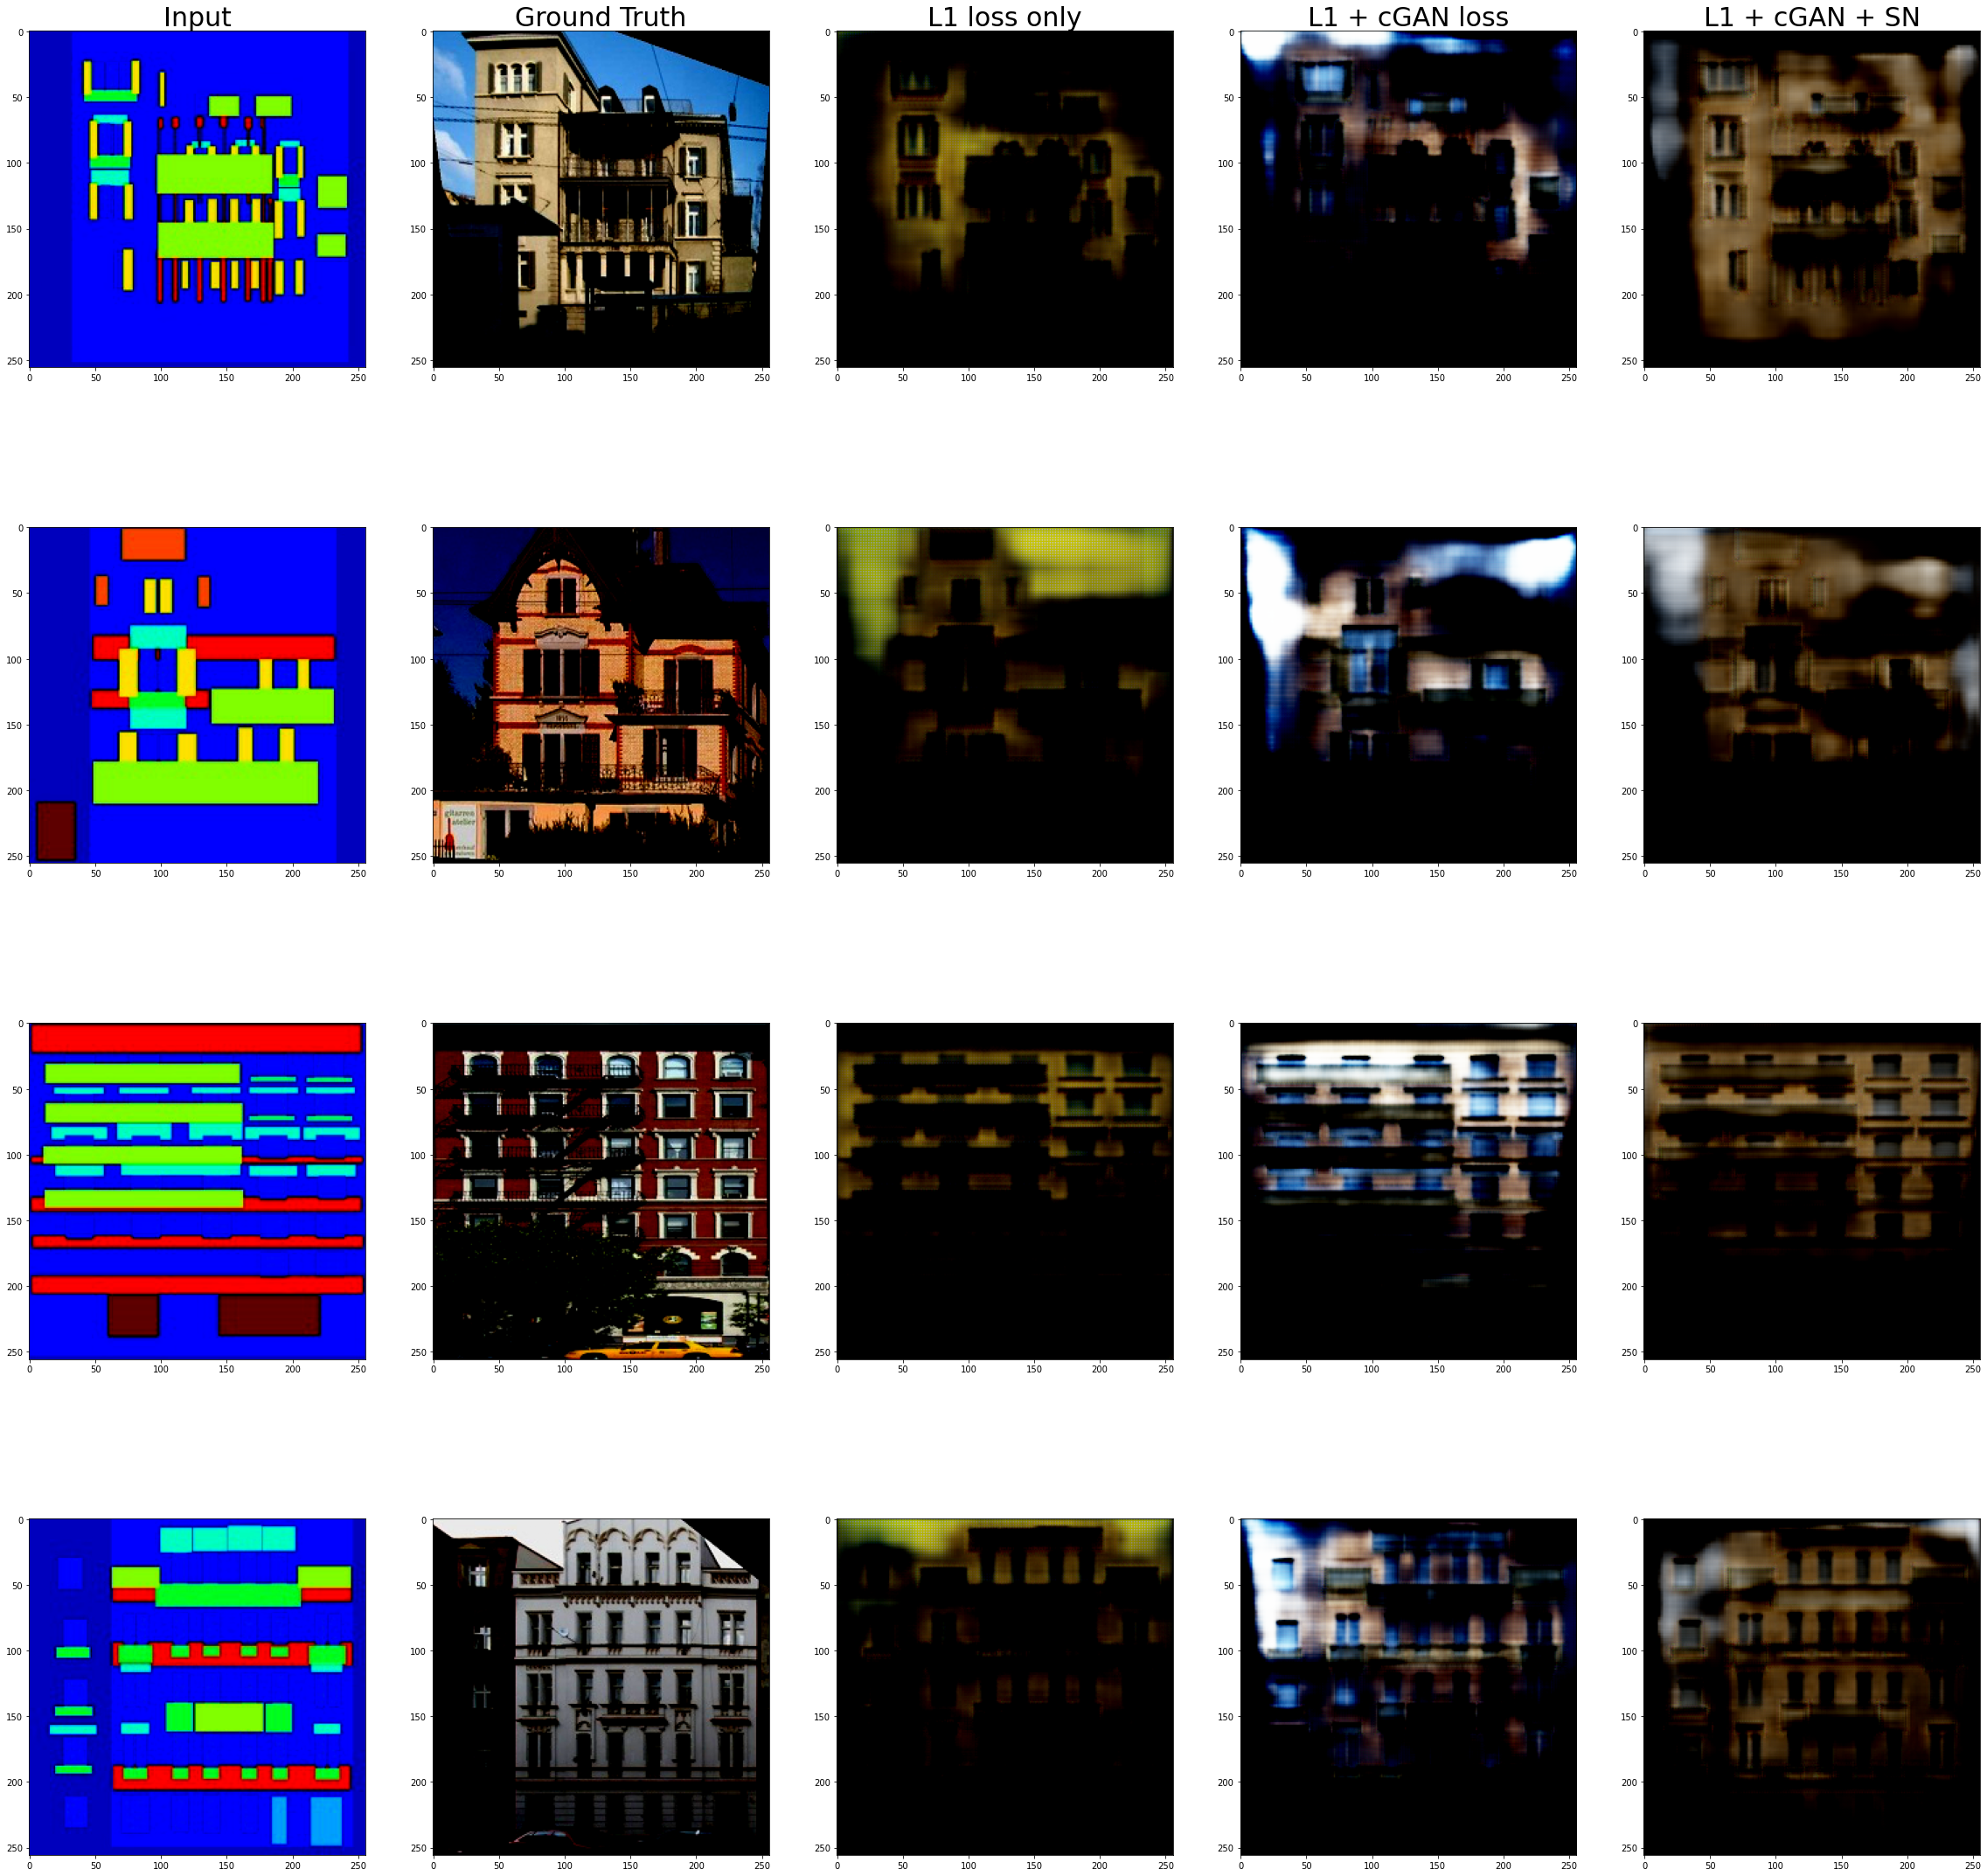

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first


netG = netG.to(device)
netGL1 = netGL1.to(device)
netG.eval()
netGL1.eval()
##########--WRITE YOUR CODE HERE--##########
def show_img_pair(data, n):
    # convert the pixels back to [0, 1] when visualizing
    plt.figure()
    _, axxr  = plt.subplots(n, 5, figsize = (40, 40))
    axxr[0, 0].set_title('Input', fontsize = 30)
    axxr[0, 1].set_title('Ground Truth', fontsize = 30)
    axxr[0, 2].set_title('L1 loss only', fontsize = 30)
    axxr[0, 3].set_title('L1 + cGAN loss', fontsize = 30)
    axxr[0, 4].set_title('L1 + cGAN + SN', fontsize = 30)

    for i in range (n):
        image1 = data[i][0]
        image2 = data[i][1]
        
        #image1, image2 = denormalize(s_left, s_right)
        #image1 = T.Resize((256,256))(image1).to(device)
        #image2 = T.Resize((256,256))(image2).to(device)
        image1 = image1.to(device).unsqueeze(0)
        image2 = image2.to(device).unsqueeze(0)
        image3 = netGL1(image1).permute(0, 2, 3, 1).detach().cpu().numpy()
        image4 = netG(image1).permute(0, 2, 3, 1).detach().cpu().numpy()
        image5 = netGSN(image1).permute(0, 2, 3, 1).detach().cpu().numpy()
        image1 = image1.permute(0, 2, 3, 1).detach().cpu().numpy()
        image2 = image2.permute(0, 2, 3, 1).detach().cpu().numpy()
        image1 = image1.squeeze(0)
        image2 = image2.squeeze(0)
        image3 = image3.squeeze(0)
        image4 = image4.squeeze(0)
        image5 = image5.squeeze(0)

        axxr[i,0].imshow(image1)
        axxr[i,1].imshow(image2)
        axxr[i,2].imshow(image3)
        axxr[i,3].imshow(image4)
        axxr[i,4].imshow(image5)
    ##########-------END OF CODE-------##########    
    
    
show_img_pair(test, 4)

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import torch 
netG.eval()
netGL1.eval()
netGSN.eval()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def resize_image(x):
  with torch.no_grad():
    x = up(x)
    x = inception_model(x)
    return F.softmax(x).data.cpu().numpy()
def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
  with torch.no_grad():
    split_scores = []
    pred = np.zeros((images.shape[0], 1000))
    data = torch.utils.data.DataLoader(images, 4)
    for i,x in enumerate(data):
        x = x.to(device).type(dtype)
        batch_variable = torch.autograd.Variable(x)
        bs_i = x.shape[0]

        pred[i*4:i*4+bs_i] = resize_image(batch_variable)
    for j in range(splits):
        p = pred[j*(images.shape[0] // splits): (j+1) * (images.shape[0] // splits), :]
        py = np.mean(p, axis = 0)
        sc =[]
        for k in range(p.shape[0]):
            px = p[k, :]
            sc.append(entropy(px, py))
        split_scores.append(np.exp(np.mean(sc)))

    ##########-------END OF CODE-------##########
    return np.mean(split_scores)

def transform_data(model, data):
  with torch.no_grad():
    out = []
    model = model.to(device)
    for i,_ in data:
        i = i.to(device)
        output_i = model(i)
        out.append(output_i)
    final_output = torch.cat(tuple(out), dim = 0)
    return final_output
testData = torch.utils.data.DataLoader(dataset=test, batch_size=1)
test_pred = transform_data(netG, testData)
test_pred_l1 = transform_data(netGL1, testData)
test_pred_SN = transform_data(netGSN, testData)
inception_s_l1 = inception_score(test_pred_l1)
inception_s = inception_score(test_pred)
inception_s_sn = inception_score(test_pred_SN)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1 + cGAN + SN", f"{inception_s_sn:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---CSE527-22F-HW5.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
